In [4]:
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [5]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine('sqlite:///Hawaii_db.sqlite')

In [7]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
Base.classes.keys()

['Measurement', 'Station']

In [11]:
Measurement = Base.classes.Measurement
Station = Base.classes.Station

In [13]:
session = Session(engine)

<IPython.core.display.Javascript object>


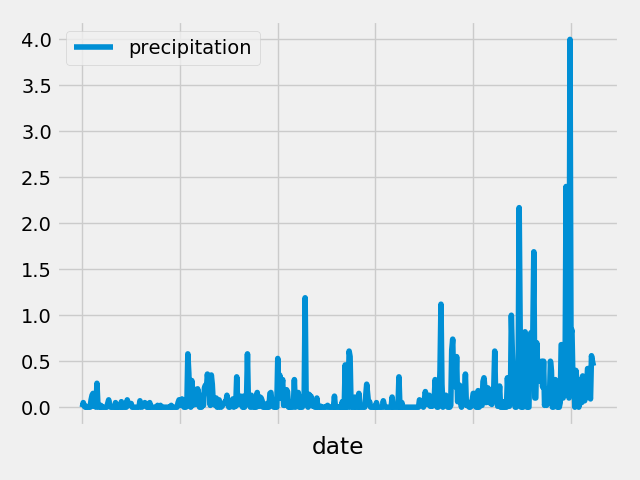

In [15]:
prev_year = dt.date.today() - dt.timedelta(days=365)


results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()


df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)


df.plot(x_compat=True)

plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

In [17]:
df.describe()

,precipitation
count,524.000000
mean,0.121489
std,0.291781
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.000000


In [18]:
session.query(func.count(Station.station)).all()

[(18)]

In [19]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


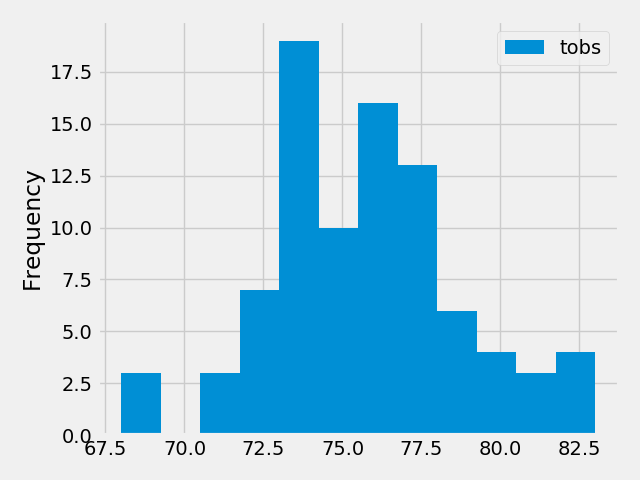

In [21]:
import datetime as dt
from pandas.plotting import table
prev_year = dt.date.today() - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

In [22]:
def calc_temps(start_date, end_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.3921568627451, 74.0)]


In [23]:
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.1025641025641 74.0


<IPython.core.display.Javascript object>


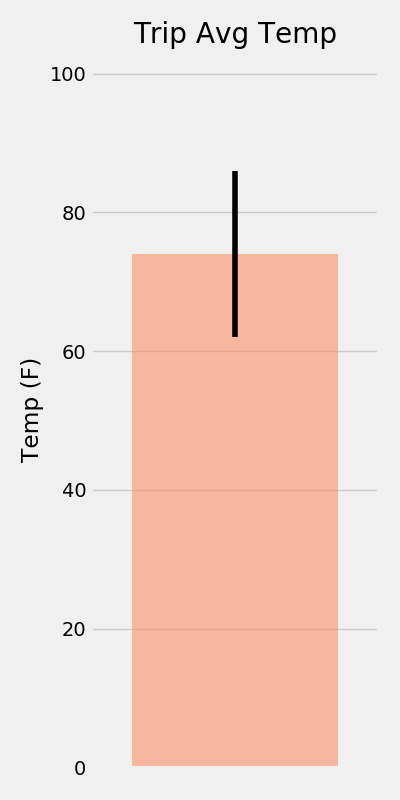

In [24]:
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [25]:
start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6200000000000001), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9, 0.5), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.2), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.12), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [26]:
def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.06, 77.0)]

In [27]:
trip_start = '2018-01-01'
trip_end = '2018-01-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.06, 77.0),
 (60.0, 69.40816326530613, 77.0),
 (62.0, 68.83333333333333, 77.0),
 (58.0, 69.83636363636364, 76.0),
 (56.0, 68.0, 76.0),
 (61.0, 68.88679245283019, 76.0),
 (57.0, 68.38181818181818, 76.0)]

In [28]:
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.060000,77.0
2018-01-02,60.0,69.408163,77.0
2018-01-03,62.0,68.833333,77.0
2018-01-04,58.0,69.836364,76.0
2018-01-05,56.0,68.000000,76.0


<IPython.core.display.Javascript object>


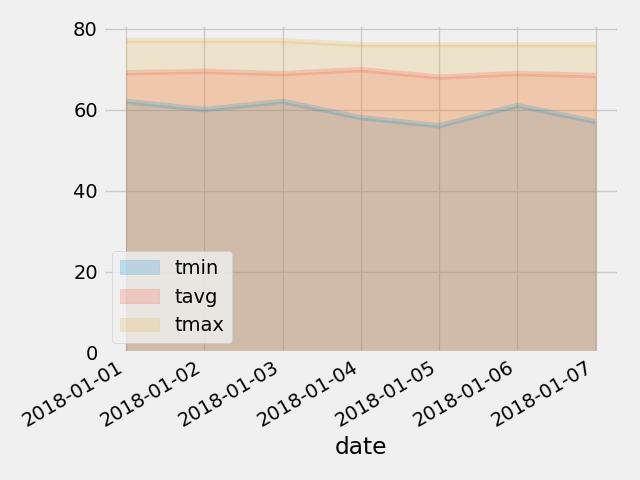

In [29]:
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.show()